In [103]:
invisible(capture.output({
library(dplyr) # for functions
}))
profiles_dir <- "/home/ido/br_stat_profiler/qerr_profiles/NPC2017_5_patients"
profile <- "All.GATKReport.mm_cntxt.4.profile.raw.v0_nW.csv"
file_path_4 <- file.path(profiles_dir, profile)
profile_4 <- read.csv(file_path_4, na.strings = "", row.names = 1)

profile <- "All.GATKReport.mm_cntxt.5.profile.raw.v0_nW.csv"
file_path_5 <- file.path(profiles_dir, profile)
profile_5 <- read.csv(file_path_5, na.strings = "", row.names = 1)

profile <- "All.GATKReport.mm_cntxt.6.profile.raw.v0_nW.csv"
file_path_6 <- file.path(profiles_dir, profile)
profile_6 <- read.csv(file_path_6, na.strings = "", row.names = 1)


#### Util Functions

In [128]:
invisible(capture.output({
    library(matrixStats)
}))
cutoff_complete_cases <- function(cutoff,profile_df) {
    profile_df[abs(profile_df) < cutoff] <- NA
    data.frame(profile_df[complete.cases(profile_df), ])
}

cutoff_scale_complete_cases <- function(cutoff, profile_df) {
    df <- data.frame()
    df <- cutoff_complete_cases(cutoff, profile_df) %>%
        scale() %>% as.data.frame() %>% mutate_all(~as.numeric(.))
    df
}

ALL_ROWS = -1
get_top_sds <- function(sds_count, df) {
    # print(sds_count)
    # print(nrow(df))
    sds <- rowSds(as.matrix(df), na.rm = TRUE)
    o <- order(sds, decreasing = TRUE)
    if (sds_count > nrow(df)) {
        return (NA)
    }
    if (sds_count == ALL_ROWS) {
        return(df[o,])
    }
    df[o[1:sds_count],]
}

cutoff_and_get_top_sds <- function(sds_count, cutoff, profile_df) {
    prf_cutoffed_df <- cutoff_scale_complete_cases(cutoff, profile_df)
    return (get_top_sds(sds_count, prf_cutoffed_df))
}


get_function_grid <- function(top_sds, cutoffs, df, my_func, method = NULL) {   
    # print(method)
    # result <- outer(top_sds, cutoffs, Vectorize(function(a, b) my_func(a, b, df)))
    result_mat <- matrix(nrow = 0, ncol = 0)
    if (is.null(method)) {
        result_mat <- outer(top_sds, cutoffs, Vectorize(function(a, b) my_func(a, b, df)))
    }else{
        result_mat <- outer(top_sds, cutoffs, Vectorize(function(a, b) my_func(a, b, df, method)))
    }

    result_df <- data.frame(result_mat)
    top_sds[length(top_sds)] = "ALL_ROWS"
    rownames(result_df) <- top_sds
    colnames(result_df) <- cutoffs
    result_df
}


##################################################### PCI ######################################################

get_PCI <- function(profile_df, method="complete") {
    cleaned_scaled_prf = data.frame()
    cleaned_scaled_prf <- profile_df
    
    d <- dist(t(cleaned_scaled_prf))  
    h_cl <- hclust(d, method)
    cluster_labels <- cutree(h_cl, k = 2)  # Assuming you want to separate into 2 clusters (tumor and normal)

    sample_names <- colnames(cleaned_scaled_prf)
    tumor_samples <- sample_names[grep("T\\.bam$",sample_names)]
    normal_samples <- sample_names[grep("N\\.bam$",sample_names)]
    # normal_indices <- grep("N\\.bam$", names(cluster_labels))
    # tumor_indices <- grep("T\\.bam$", names(cluster_labels))

    concordant_pairs <- sum(cluster_labels[tumor_samples]  == 2) + sum(cluster_labels[normal_samples]  == 1) 
    discordant_pairs <-  sum(cluster_labels[normal_samples]  == 2) + sum(cluster_labels[tumor_samples]  == 1) 
    total_pairs <- concordant_pairs + discordant_pairs
    PCI <- concordant_pairs / total_pairs
    round(PCI,2)
}

cutoff_and_get_PCI <- function(cutoff, profile_df, method = "complete") {
    cleaned_scaled_prf = data.frame()
    cleaned_scaled_prf <- cutoff_scale_complete_cases(cutoff, profile_df)
    get_PCI(cleaned_scaled_prf, method)
}


cutoff_and_top_sds_get_PCI <- function(sds_count, cutoff, profile_df, method="complete") {
    cleaned_scaled_prf <- data.frame(cutoff_and_get_top_sds(sds_count, cutoff, profile_df))
    if (anyNA(cleaned_scaled_prf[1,1])) {
        return(NA)
    }
    get_PCI(cleaned_scaled_prf,method)
}



get_pci_grid <- function(top_sds, cutoffs, df, method="complete") {   
        return(get_function_grid(top_sds, cutoffs, df, cutoff_and_top_sds_get_PCI, method))
}

####################################  Silhouette #################################
library(cluster)
get_silhouette_score <- function(df) {
    d <- dist(t(df))
    h_cl <- hclust(d)
    si <- silhouette(cutree(h_cl, k=2), d)
    round(summary(si)$avg.width,2)
}

cutoff_and_get_silhouette_score <- function(cutoff, profile_df){
    cleaned_scaled_prf <- data.frame()
    cleaned_scaled_prf <-  cutoff_scale_complete_cases(cutoff, profile_df)
    return(get_silhouette_score(cleaned_scaled_prf))
}

cutoff_and_top_sds_get_silhouette_score <- function(sds_count, cutoff, profile_df) {
    cleaned_scaled_prf <- data.frame(cutoff_and_get_top_sds(sds_count, cutoff, profile_df))
    if (anyNA(cleaned_scaled_prf[1,1])) {
        return(NA)
    }
    get_silhouette_score(cleaned_scaled_prf)
}


get_silhouette_grid <- function(top_sds, cutoffs, df) {   
        return(get_function_grid(top_sds, cutoffs, df, cutoff_and_top_sds_get_silhouette_score))
}

############################################ T-test ############################################################

add_t_test <- function(df){
    tumor_cols <- colnames(df)[grep("T\\.bam$", colnames(df))]
    normal_cols <- colnames(df)[grep("N\\.bam$", colnames(df))]

    p_values <- apply(df, 1, function(row) {
    ttest_result <- t.test(row[tumor_cols], row[normal_cols])
    ttest_result$p.value
    })
    t_test_df = data.frame(df)
    t_test_df["T-Test"] = p_values
    return(t_test_df)
} 


get_avg_ttest_profile <- function(cutoff, profile_df) {
    t_test_df <- data.frame()
    t_test_df <- add_t_test(cutoff_scale_complete_cases(cutoff, profile_df))
    round(mean(t_test_df[,"T-Test"]),2)
}



cutoff_and_top_sds_get_avg_ttest <- function(sds_count, cutoff, profile_df) {
    cleaned_scaled_prf <- data.frame(cutoff_and_get_top_sds(sds_count, cutoff, profile_df))
    if (anyNA(cleaned_scaled_prf[1,1])) {
        return(NA)
    }
    t_test_df <- data.frame()
    t_test_df <- add_t_test(cleaned_scaled_prf)
    round(mean(t_test_df[,"T-Test"]),2)
}

get_avg_ttest_grid <- function(top_sds, cutoffs, df) {   
        return(get_function_grid(top_sds, cutoffs, df, cutoff_and_top_sds_get_avg_ttest))
}
################################################################################################33
library(ggplot2)
# create_grid_heatmap <- function(grid_df, grid_title, my_font_size=5, inversed_colors=FALSE){
#   df<-grid_df
#   df$row <- factor(rownames(grid_df), levels = rownames(grid_df))
#   # df$row <- rownames(grid_df)
#   df <- tidyr::pivot_longer(df, -row, names_to = "col", values_to = "value")

# low_color   = ifelse(inversed_colors, "royalblue", "white")
# high_color  = ifelse(inversed_colors, "white", "royalblue")

# max_values <- subset(df, value == max(value))

# # Create the heatmap using ggplot2
#   plot <- ggplot(df, aes(x = col, y = row, fill = value)) + 
#     geom_tile(color = "gray70") +
#     scale_fill_gradient(low = low_color, high = high_color) +
#     # geom_text(aes(label = value), fontface = "bold", color = "black", size=5) +
#     geom_text(aes(label = value), fontface = "bold", color = "black", size=my_font_size) +
#     labs(title = grid_title, x = "cutoff", y = "top_sds#") +
#         theme_bw() +
#     theme(
#       text = element_text(size = 15, face = "bold"),
#       axis.text = element_text(size = 15, face = "bold"),
#       legend.title = element_text(face = "bold"),
#       legend.text = element_text(face = "bold")
#     )
#   return(plot)
# }

create_grid_heatmap <- function(grid_df, grid_title, my_font_size=5, inversed_colors=FALSE){
  df<-grid_df
  df$row <- factor(rownames(grid_df), levels = rownames(grid_df))
  # df$row <- rownames(grid_df)
  df <- tidyr::pivot_longer(df, -row, names_to = "col", values_to = "value")

  low_color   = ifelse(inversed_colors, "royalblue", "white")
  high_color  = ifelse(inversed_colors, "white", "royalblue")


 extreme_value <- ifelse(inversed_colors, min(df$value, na.rm =TRUE), max(df$value, na.rm = TRUE))

# Create the heatmap using ggplot2
  plot <- ggplot(df, aes(x = col, y = row, fill = value,label = value)) + 
    geom_tile(color = "gray70") +
    scale_fill_gradient(low = low_color, high = high_color) +
      geom_text(color = "black", size=my_font_size) +
      geom_text(data = subset(df, value == extreme_value), fontface = "bold", color = "black", size = my_font_size) +

    labs(title = grid_title, x = "cutoff", y = "top_sds#") +
        theme_bw() +
    theme(
      text = element_text(size = 15, face = "bold"),
      axis.text = element_text(size = 15, face = "bold"),
      legend.title = element_text(face = "bold"),
      legend.text = element_text(face = "bold")
    )
  return(plot)
}

### Noise cleaning for increased sensitivity 
1) Extract high Qerrs by using **Symetrical Cutoff**
2) Using **top SDs**

#### Best solution 

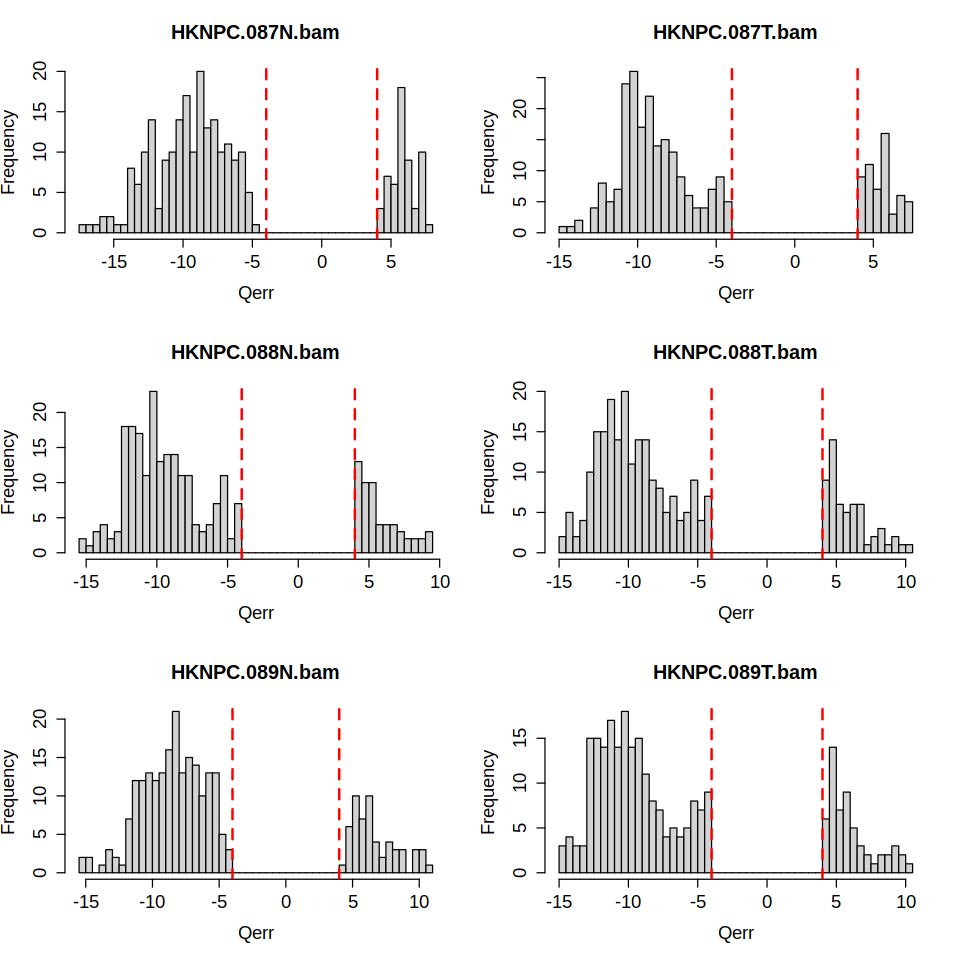

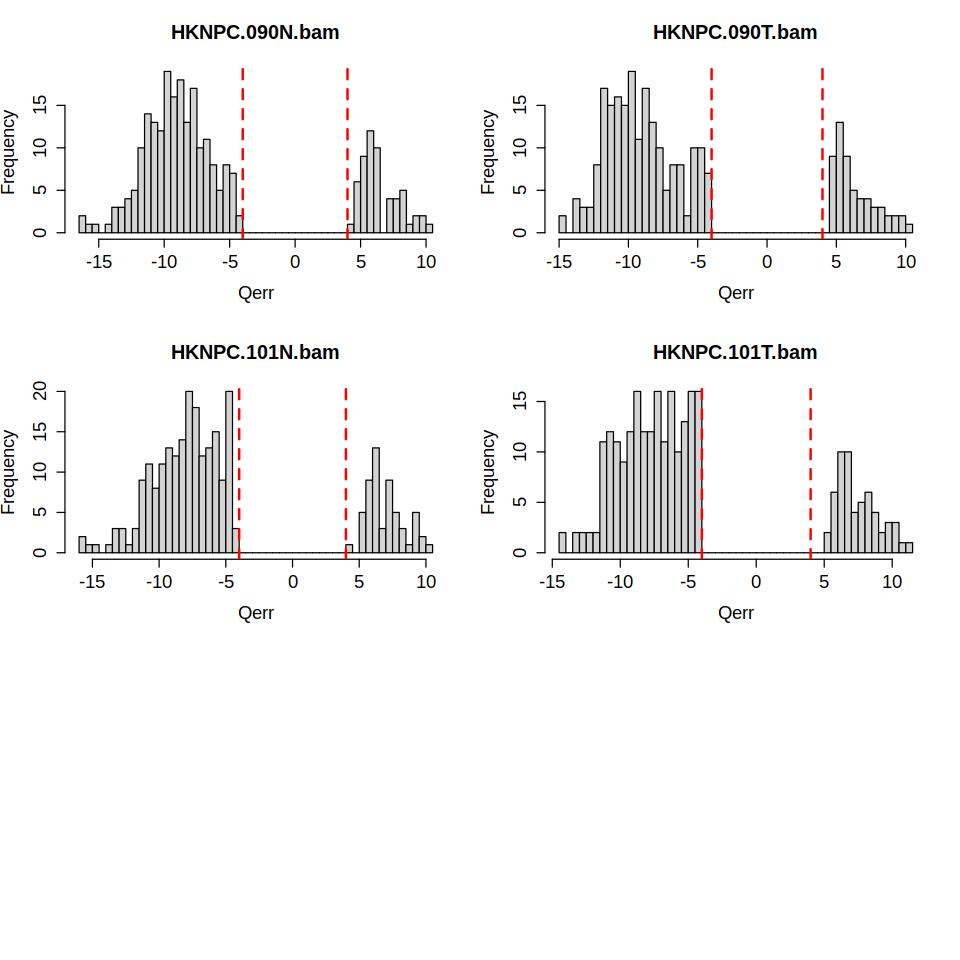

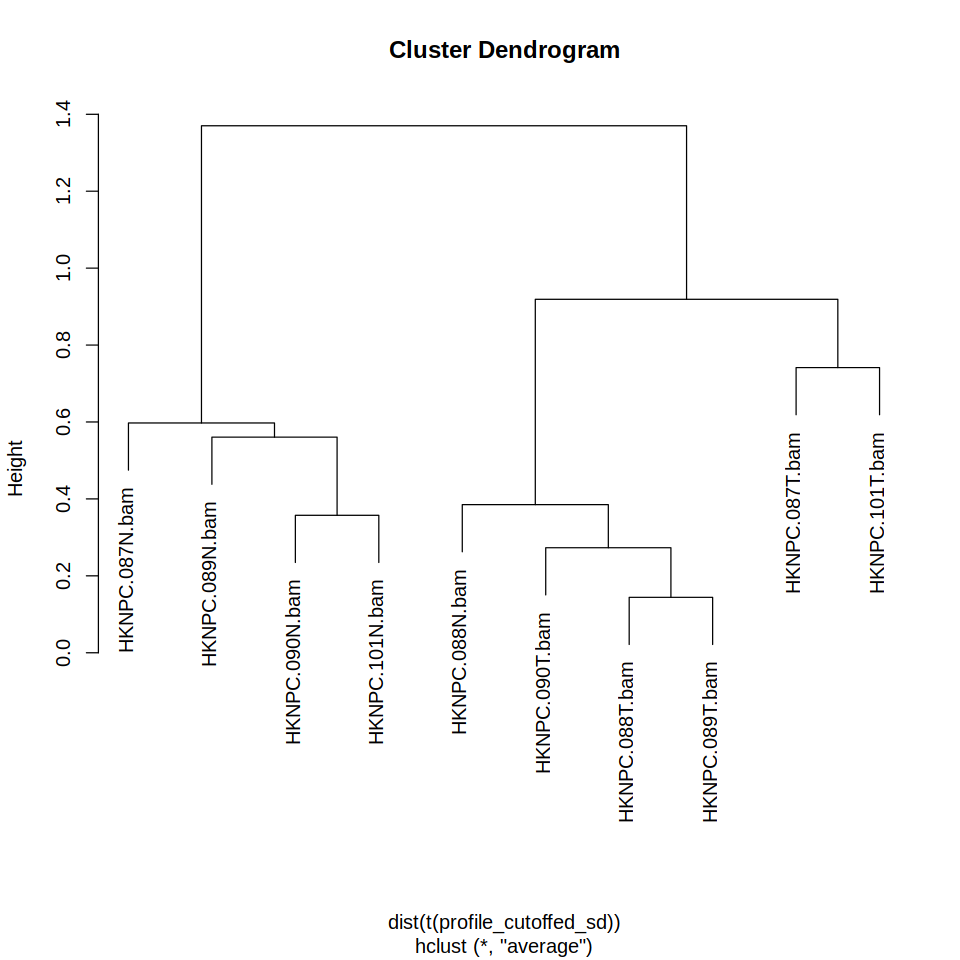

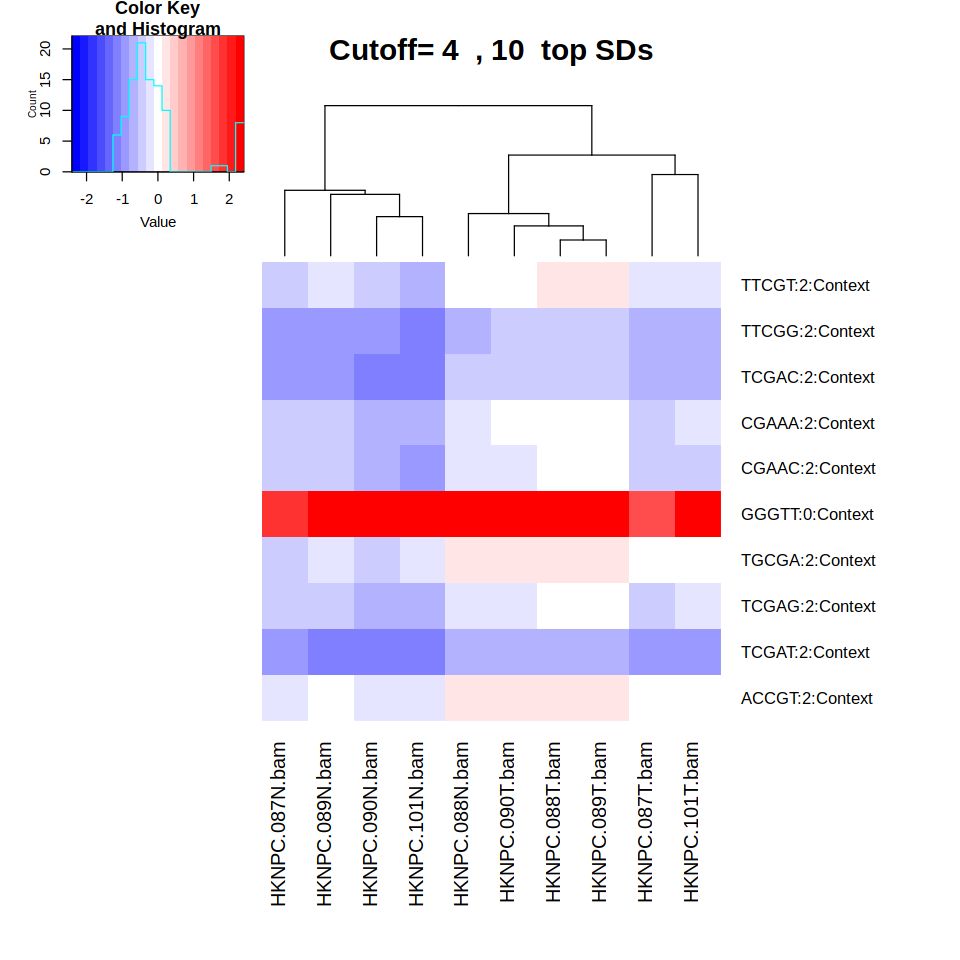

In [129]:
cell_profile = profile_5

CUTOFF = 4
TOP_SDS <- 10
best_method <- "average"

profile_cutoffed <- cutoff_complete_cases(CUTOFF, cell_profile)

options(repr.plot.width = 8, repr.plot.height = 8)
par(mfrow = c(3, 2))  # Set the plot layout to 2x2
for (col in 1:ncol(profile_cutoffed)) {
  hist(profile_cutoffed[, col],main = colnames(profile_cutoffed)[col], xlab = "Qerr", breaks = 40,
  ,cex.axis = 1.4,  cex.lab = 1.4,cex.main = 1.5)
  abline(v = CUTOFF, col = "red", lty = "dashed", lwd = 2)
  abline(v = -CUTOFF, col = "red", lty = "dashed", lwd = 2)
}

profile_cutoffed_sd <- cutoff_and_get_top_sds(TOP_SDS, CUTOFF, cell_profile)

# hclustering
hc_result <- hclust(dist(t(profile_cutoffed_sd)), method = best_method)
par(mfrow = c(1,1))
plot(hc_result)
options(repr.plot.width = 8, repr.plot.height = 8)

# library(ggcorrplot)
invisible(capture.output({
  library(ggplot2)
  library(gplots)
}))
main_title = paste("Cutoff=", CUTOFF, " ,", TOP_SDS, " top SDs")
# mtext("Super Title", outer = TRUE, cex = 1.5, line = 1)
par(mar = c(5, 6, 4, 2))
heatmap.2(as.matrix(profile_cutoffed_sd),  
  cexRow = 1, cexCol = 1.2, margins =c(12,12), scale = "none",
  Colv = as.dendrogram(hc_result),
  dendrogram = "column",
  # clustering_method_columns = best_method,
  main=main_title,
  trace = "none", Rowv=NA,
  col = colorRampPalette(c("blue", "white", "red"))(21),  
  lty = 2, lwd = 0.5)

### **Metrics for correct clutering**
1) Purity-based Clustering Index (**PCI**) - correctness of clustering
2) **Silhouette-score** - Overall clustering quality (homogenity + seperation)

In [130]:
top_sds <- c(5, 10, 20, 50, 100, 200, 500, 1000, 5000, 10000, 20000, 50000, ALL_ROWS)
cutoffs <- seq(0, 5, by = 0.5)
pci_grid_4_df <- get_pci_grid(top_sds, cutoffs, profile_4)
pci_grid_5_df <- get_pci_grid(top_sds, cutoffs, profile_5)
pci_grid_6_df <- get_pci_grid(top_sds, cutoffs, profile_6)

pci_grid_4_avg_df <- get_pci_grid(top_sds, cutoffs, profile_4, "average")
pci_grid_5_avg_df <- get_pci_grid(top_sds, cutoffs, profile_5, "average")
pci_grid_6_avg_df <- get_pci_grid(top_sds, cutoffs, profile_6, "average")

# silhouette_grid_4_df <- get_silhouette_grid(top_sds, cutoffs, profile_4)
# silhouette_grid_5_df <- get_silhouette_grid(top_sds, cutoffs, profile_5)

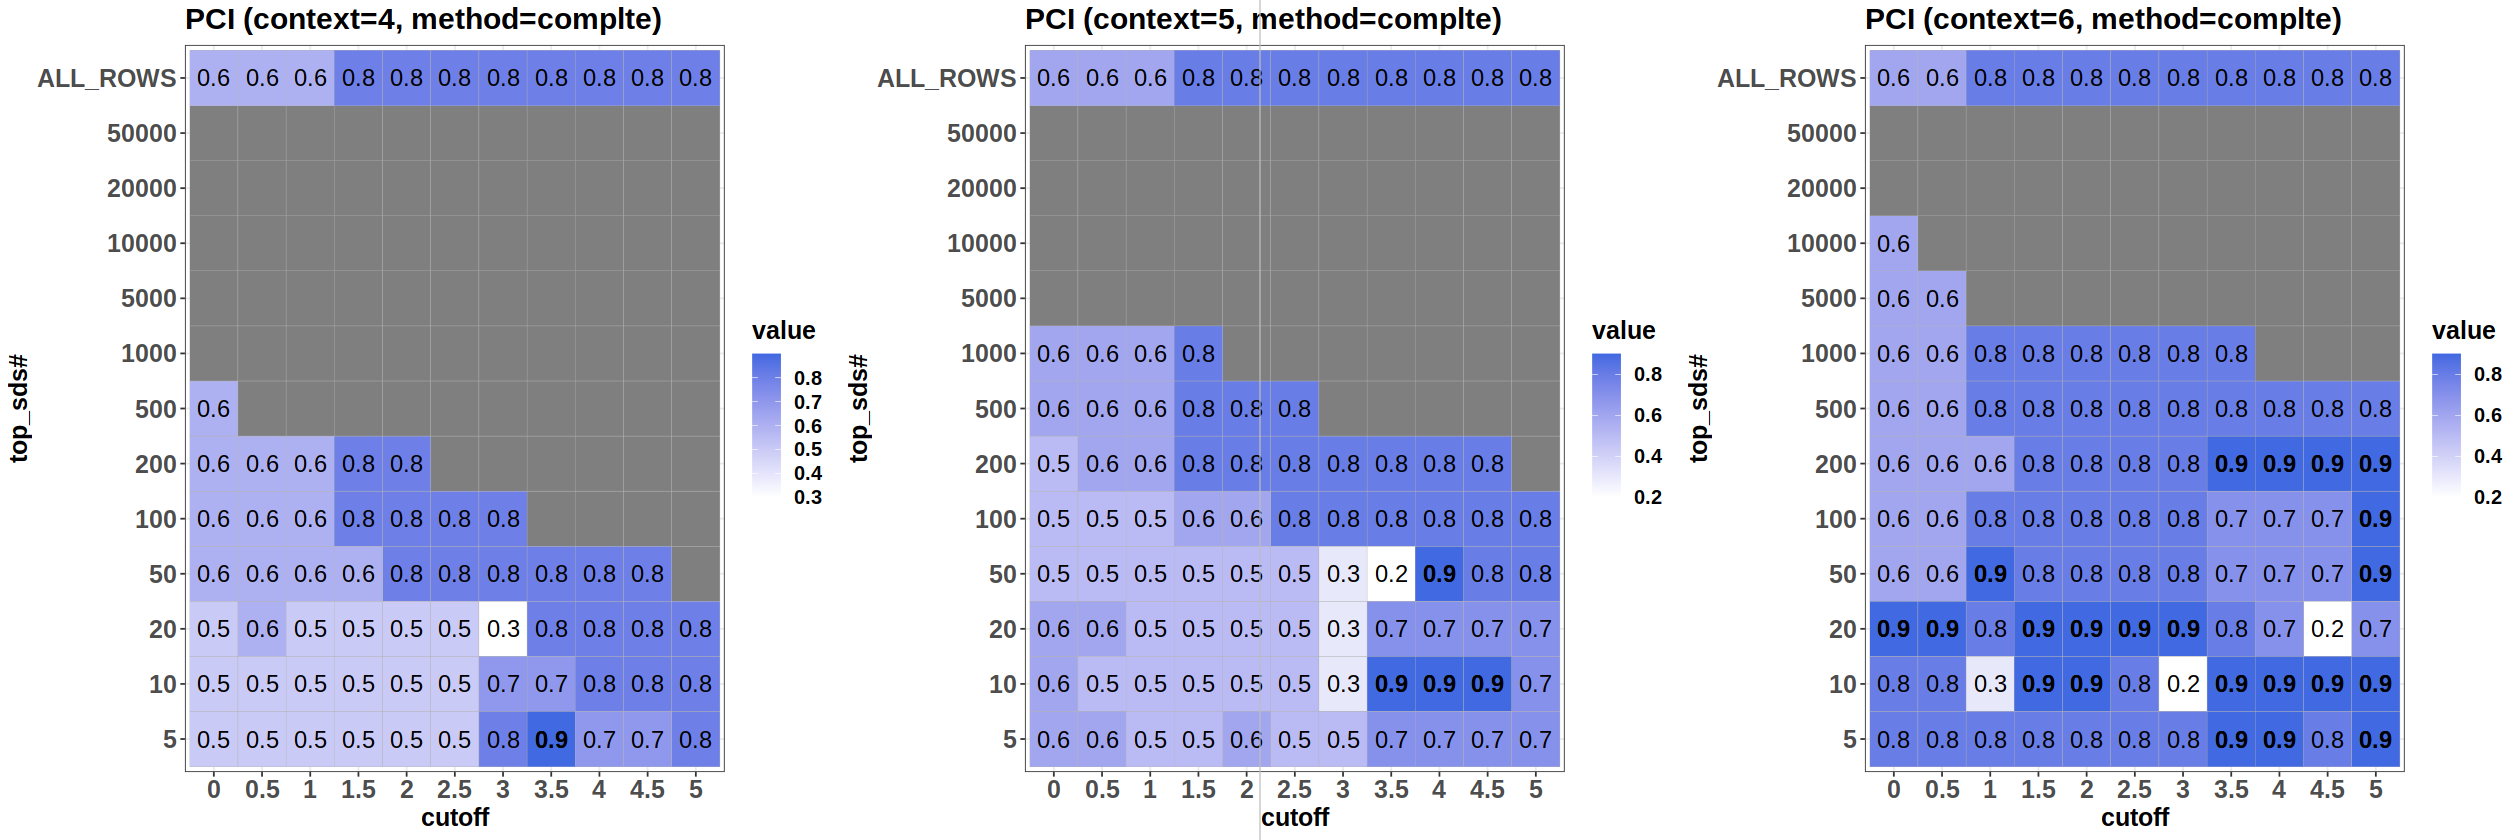

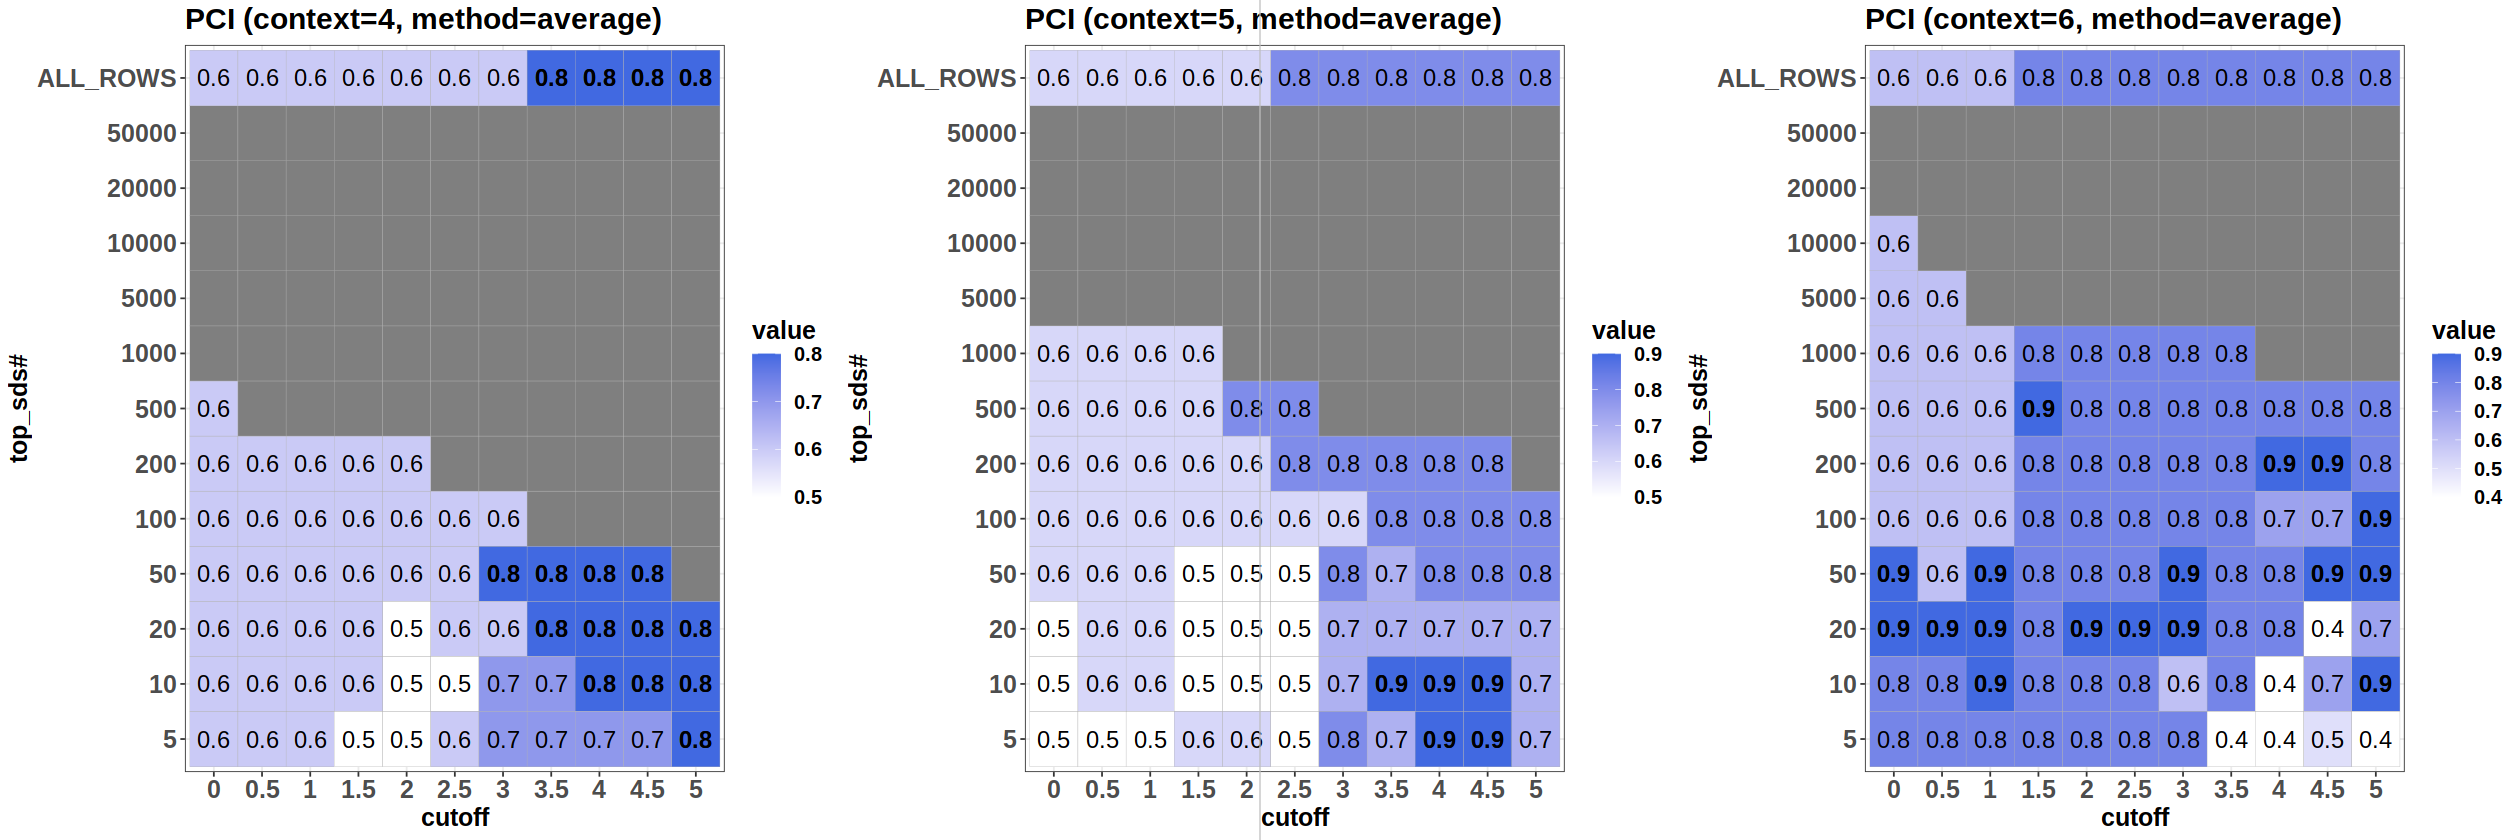

In [131]:
suppressWarnings({
    library(ggplot2)
    library(gridExtra)
    library(grid)

    # Arrange the plots side by side
    options(repr.plot.width = 21, repr.plot.height = 7)

    separator <- linesGrob(x = unit(c(0.5, 0.5), "npc"), y = unit(c(0, 1), "npc"),
                        gp = gpar(lwd = 1, col = "gray"))


    grid.arrange(
        create_grid_heatmap(pci_grid_4_df, "PCI (context=4, method=complte)"), 
        create_grid_heatmap(pci_grid_5_df, "PCI (context=5, method=complte)"), 
        create_grid_heatmap(pci_grid_6_df, "PCI (context=6, method=complte)"), 
        ncol = 3)
    grid.draw(separator)

    grid.arrange(
        create_grid_heatmap(pci_grid_4_avg_df, "PCI (context=4, method=average)"), 
        create_grid_heatmap(pci_grid_5_avg_df, "PCI (context=5, method=average)"), 
        create_grid_heatmap(pci_grid_6_avg_df, "PCI (context=6, method=average)"), 
        ncol = 3)
    grid.draw(separator)

    # grid.arrange(
    #     create_grid_heatmap(silhouette_grid_4_df, "Silhouette score context=4"), 
    #     create_grid_heatmap(silhouette_grid_5_df, "Silhouette score context=5"), 
    #     ncol = 2)
    # grid.draw(separator)
})

### **Metrics for correct clutering (Cont.)**
3) **Average t-test pval** - metric for separation

In [134]:
top_sds <- c(5, 10, 20, 50, 100, 200, 500, 1000, 5000, 10000, 20000, 50000, ALL_ROWS)
cutoffs <- seq(0, 5, by = 0.5)


avg_ttest_grid_4_df <- get_avg_ttest_grid(top_sds, cutoffs, profile_4)
avg_ttest_grid_5_df <- get_avg_ttest_grid(top_sds, cutoffs, profile_5)
avg_ttest_grid_6_df <- get_avg_ttest_grid(top_sds, cutoffs, profile_6)


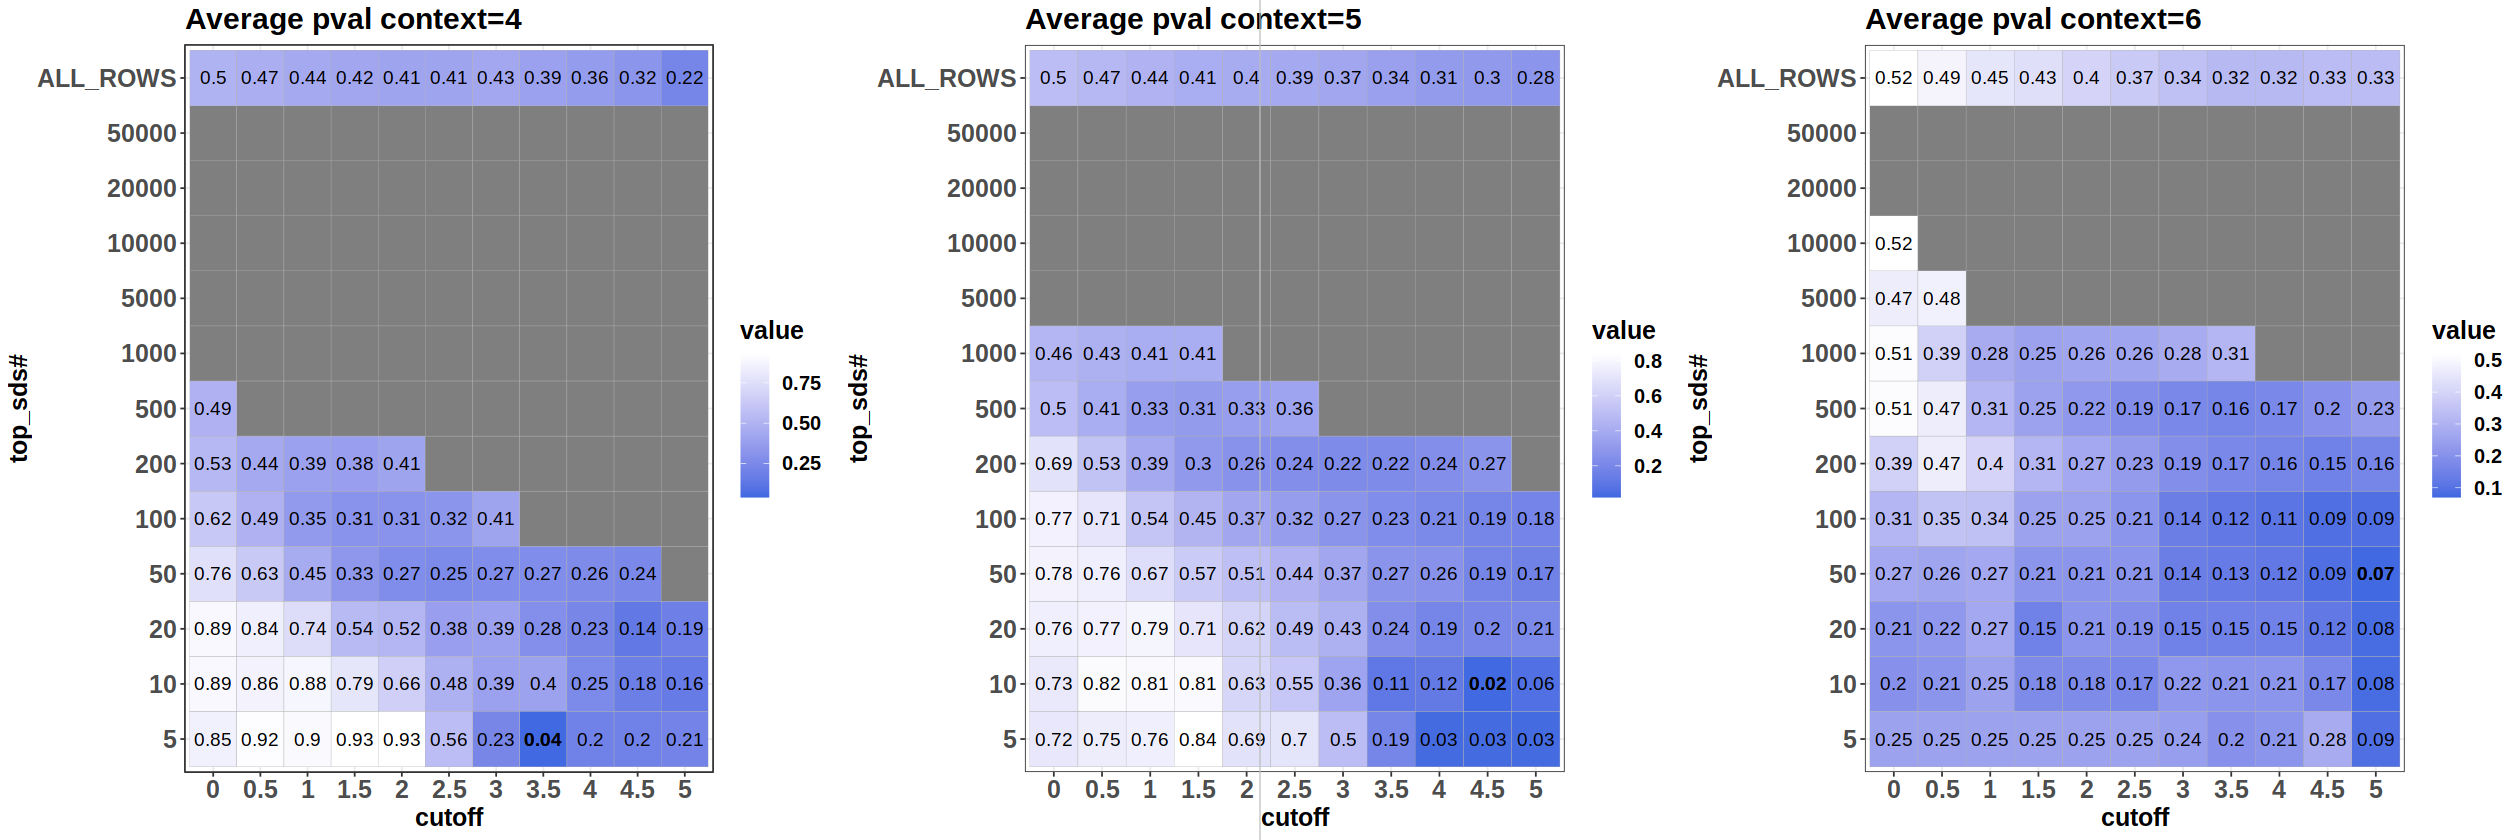

In [135]:
suppressWarnings({
    library(ggplot2)
    library(gridExtra)
    library(grid)

# Arrange the plots side by side
options(repr.plot.width = 21, repr.plot.height = 7)

separator <- linesGrob(x = unit(c(0.5, 0.5), "npc"), y = unit(c(0, 1), "npc"),
                       gp = gpar(lwd = 1, col = "gray"))


grid.arrange(
    create_grid_heatmap(avg_ttest_grid_4_df, "Average pval context=4", 4, inversed_colors = TRUE), 
    create_grid_heatmap(avg_ttest_grid_5_df, "Average pval context=5", 4,  inversed_colors = TRUE), 
    create_grid_heatmap(avg_ttest_grid_6_df, "Average pval context=6", 4,  inversed_colors = TRUE), 
    ncol = 3)
grid.draw(separator)

})